# PyTorch Tutorial - *Duke University*

In [1]:
import torch
print(torch.__version__)
x = torch.rand(2,3)
print(x)

1.8.1
tensor([[0.5600, 0.9465, 0.1332],
        [0.2671, 0.7182, 0.9530]])


Given training data and a model to fit, how do we learn the parameters?

Risk Minimization
- loss function is the penalty for poor prediction
- want to minimize average loss

Loss function:
- $\sigma(z)$ = predicted probability
- y = true label

![](LogRegFunc.png)

## **Logistic Regression** 
- using MNIST for digit classification

In [2]:
# tqdm is a progress bar function library
from tqdm import tqdm 

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch

``torchvision`` package makes it easy to do data processing for the data to fit in a model

Download the MNIST dataset and do the TRAIN/TEST split

In [3]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root="./datasets", 
                             train=True, 
                             transform=transforms.ToTensor(), 
                             download=True)

mnist_test = datasets.MNIST(root="./datasets", 
                            train=False, 
                            transform=transforms.ToTensor(), 
                            download=True)


In [4]:
print("Number of MNIST training examples: {}".format(len(mnist_train)))
print("Number of MNIST test examples: {}".format(len(mnist_test)))

Number of MNIST training examples: 60000
Number of MNIST test examples: 10000


Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
The label for this image: 1


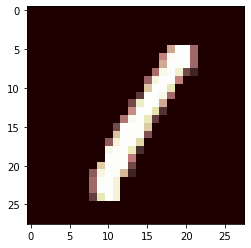

In [5]:
# Pick out the 4th (0-indexed) example from the training set
image, label = mnist_train[3]

# Plot the image
print("Default image shape: {}".format(image.shape))
image = image.reshape([28,28])
print("Reshaped image shape: {}".format(image.shape))
plt.imshow(image, cmap="pink")

# Print the label
print("The label for this image: {}".format(label))

to work directly with the data as a torchvision.dataset, we'll find it useful to use a DataLoader, which will take care of shuffling and batching:

In [6]:
train_loader = torch.utils.data.DataLoader(mnist_train, 
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(mnist_test, 
                                          batch_size=100, 
                                          shuffle=False)

draw a minibatch from DataLoader

In [7]:
data_train_iter = iter(train_loader)
images, labels = data_train_iter.next()

print("Shape of the minibatch of images: {}".format(images.shape))
print("Shape of the minibatch of labels: {}".format(labels.shape))

Shape of the minibatch of images: torch.Size([100, 1, 28, 28])
Shape of the minibatch of labels: torch.Size([100])


## Forward Pass
- data inputs (x) are images (2D) = vectors
- flatten the vectors and use ``view()`` which is the same as NumPy ``reshape()``
- using a -1 is for replace 1 of the dimensions of the reshape

In [8]:
x = images.view(-1, 28*28)
print("The shape of input x: {}".format(x.shape))

The shape of input x: torch.Size([100, 784])


In [9]:
# Randomly initialize weights W
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()

# Initialize bias b as 0s
b = torch.zeros(10, requires_grad=True)

In [10]:
# Linear transformation with W and b
y = torch.matmul(x, W) + b

In [11]:
print(y[0,:])

tensor([ 0.1401, -0.4544,  0.0767,  0.3943,  0.2586, -0.3085, -0.7737, -0.1666,
         0.3639,  0.4040], grad_fn=<SliceBackward>)


In [12]:
# Option 1: Softmax to probabilities from equation
py_eq = torch.exp(y) / torch.sum(torch.exp(y), dim=1, keepdim=True)
print("py[0] from equation: {}".format(py_eq[0]))

py[0] from equation: tensor([0.1083, 0.0598, 0.1016, 0.1396, 0.1219, 0.0691, 0.0434, 0.0797, 0.1355,
        0.1410], grad_fn=<SelectBackward>)


In [13]:
# Option 2: Softmax to probabilities with torch.nn.functional
import torch.nn.functional as F
py = F.softmax(y, dim=1)
print("py[0] with torch.nn.functional.softmax: {}".format(py[0])) 

py[0] with torch.nn.functional.softmax: tensor([0.1083, 0.0598, 0.1016, 0.1396, 0.1219, 0.0691, 0.0434, 0.0797, 0.1355,
        0.1410], grad_fn=<SelectBackward>)


In [14]:
print(labels.shape)

torch.Size([100])


In [15]:
# Cross-entropy loss from equation
cross_entropy_eq = torch.mean(-torch.log(py_eq)[range(labels.shape[0]),labels])
print("cross entropy from equation: {}".format(cross_entropy_eq))

# Option 2: cross-entropy loss with torch.nn.functional
cross_entropy = F.cross_entropy(y, labels)
print("cross entropy with torch.nn.functional.cross_entropy: {}".format(cross_entropy))

cross entropy from equation: 2.286677598953247
cross entropy with torch.nn.functional.cross_entropy: 2.286677360534668


backward pass

In [17]:
# Optimizer
optimizer = torch.optim.SGD([W,b], lr=0.1)

cross_entropy.backward()

b.grad

optimizer.step()

b

tensor([-0.0020,  0.0075, -0.0063,  0.0038,  0.0005,  0.0004,  0.0012, -0.0047,
         0.0014, -0.0017], requires_grad=True)

In [18]:
print("b.grad before zero_grad(): {}".format(b.grad))
optimizer.zero_grad()
print("b.grad after zero_grad(): {}".format(b.grad))

b.grad before zero_grad(): tensor([ 0.0200, -0.0749,  0.0628, -0.0379, -0.0054, -0.0035, -0.0116,  0.0471,
        -0.0141,  0.0175])
b.grad after zero_grad(): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


model training

To train the model, we just need repeat what we just did for more minibatches from the training set. As a recap, the steps were:

Draw a minibatch
Zero the gradients in the buffers for W and b
Perform the forward pass (compute prediction, calculate loss)
Perform the backward pass (compute gradients, perform SGD step)
Going through the entire dataset once is referred to as an epoch. In many cases, we train neural networks for multiple epochs, but here, a single epoch is enough. We also wrap the train_loader with tqdm. This isn't neccessary, but it adds a handy progress bar so we can track our training progress.

In [19]:
# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

100%|██████████| 600/600 [00:04<00:00, 125.56it/s]


testing

Now let's see how we did! For every image in our test set, we run the data through the model, and take the digit in which we have the highest confidence as our answer. We then compute an accuracy by seeing how many we got correct. We're going to wrap evaluation with torch.no_grad(), as we're not interested in computing gradients during evaluation. By turning off the autograd engine, we can speed up evaluation.

In [20]:
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

100%|██████████| 100/100 [00:00<00:00, 130.77it/s]

Test accuracy: 0.9027000069618225


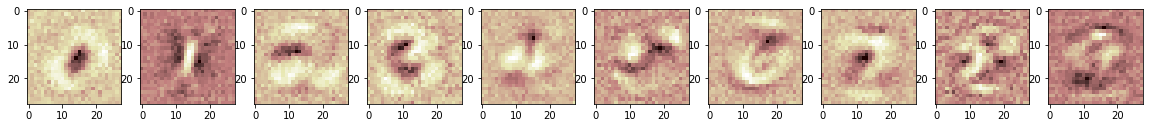

In [21]:
# Get weights
fig, ax = plt.subplots(1, 10, figsize=(20, 2))

for digit in range(10):
    ax[digit].imshow(W[:,digit].detach().view(28,28), cmap='pink')

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, x):
        return self.lin(x)

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Instantiate model
model = MNIST_Logistic_Regression()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)
    loss = criterion(y, labels)
    # Backward pass
    loss.backward()
    optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = model(x)
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9035000205039978
